In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn import metrics
import xgboost as xgb
from sklearn import svm
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    matthews_corrcoef,
    confusion_matrix,
)

In [3]:
sex= 'Female'
control = pd.read_csv(f"../result/Control_{sex}.csv")
training = pd.read_csv(f"../result/Training_{sex}.csv")

print(control.shape)
print(training.shape)

(4588, 166)
(2099, 166)


In [4]:
features = pd.concat([control,training],ignore_index=True)
features = features.drop(columns=['TWB2_ID','I_32','Label'])

#將ID排除
X = features.iloc[:,1::]
print(X.info())

feature_names = X.columns
X = [X.iloc[i,:].values.flatten().tolist() for i in range(control.shape[0]+training.shape[0])]
print('樣本數: ',len(X))

control_label=control.iloc[:,-1]
training_label=training.iloc[:,-1]
y=pd.concat([control_label,training_label],ignore_index=True)
label_encoder = LabelEncoder()
y = list(label_encoder.fit_transform(y))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6687 entries, 0 to 6686
Columns: 162 entries, AGE to MICROALB
dtypes: float64(162)
memory usage: 8.3 MB
None
樣本數:  6687


In [5]:
from collections import Counter

# 分割資料集 (training and validation sets)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"訓練集樣本數量： {len(X_train)}")
print(f"測試集樣本數量： {len(X_val)}")
train_class_distribution = Counter(y_train)
val_class_distribution = Counter(y_val)
print("訓練集中各類別樣本數量：")
print(train_class_distribution)
print("測試集中各類別樣本數量：")
print(val_class_distribution)

訓練集樣本數量： 6018
測試集樣本數量： 669
訓練集中各類別樣本數量：
Counter({0: 4124, 1: 1894})
測試集中各類別樣本數量：
Counter({0: 464, 1: 205})


In [6]:
# SMOTE
# train set use SMOTE
smote_train_X, smote_train_Y = SMOTE(random_state=42).fit_resample(X_train, y_train)
print("SMOTE train set sampling:")
print(Counter(smote_train_Y))

# train set use BSMOTE
bsmote_train_X, bsmote_train_Y = BorderlineSMOTE(
    random_state=42, kind="borderline-2"
).fit_resample(X_train, y_train)
print("BSMOTE train set sampling:")
print(Counter(bsmote_train_Y))

# test set balance
bal_x_test, bal_y_test = RandomUnderSampler(random_state=42).fit_resample(X_val, y_val)
print("Random sampling:")
print(Counter(bal_y_test))

smote_test_X, smote_test_Y = SMOTE(random_state=42).fit_resample(X_val, y_val)
print("SMOTE test set sampling:")
print(Counter(smote_test_Y))

bsmote_test_X, bsmote_test_Y = BorderlineSMOTE(random_state=42).fit_resample(X_val, y_val)
print("BSMOTE test set sampling:")
print(Counter(bsmote_test_Y))

SMOTE train set sampling:
Counter({1: 4124, 0: 4124})
BSMOTE train set sampling:
Counter({1: 4124, 0: 4124})
Random sampling:
Counter({0: 205, 1: 205})
SMOTE test set sampling:
Counter({0: 464, 1: 464})
BSMOTE test set sampling:
Counter({0: 464, 1: 464})


In [7]:
# Male
# selected_features = ['I_18', 'I_11', 'I_23', 'ANTI_HBC_AB_1', 'EYE_DIS', 'NECK_ACHE',
                    #  'BACK_AND_WAIST_ACHE', 'CARCINOMA_IN_SITU', 'DIABETES', 'GOUT']
# Female
selected_features = ['I_16', 'I_22', 'I_11', 'ORTHOPEDICS_ARTICULUS', 'EYE_DIS', 'I_18',
                    'ARTICULUS_ACHE', 'MENSTRURATION_CURR', 'I_33', 'I_24', 'SPO_HABIT',
                    'DIABETES', 'I_35', 'I_26', 'MC_DURATION', 'I_37', 'I_9', 'AGE', 'I_31',
                    'CARCINOMA_IN_SITU']

indices = [feature_names.get_loc(feature) for feature in selected_features]
print("feature num:", len(indices))

smote_train_X = [[row[i] for i in indices] for row in smote_train_X]
smote_test_X = [[row[i] for i in indices] for row in smote_test_X]
bsmote_test_X = [[row[i] for i in indices] for row in bsmote_test_X]

feature num: 20


In [8]:
def set_parameters(model, param_grid):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(smote_train_X, smote_train_Y)
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    return grid_search.best_estimator_

#xgb
param_xgb = {
    # Male
    # 'learning_rate': [0.01,0.05, 0.1],
    # 'n_estimators': [10,50,100],
    # 'max_depth': [2,3, 4],
    # 'subsample': [0.5,0.6,0.7],
    # 'colsample_bytree': [0.2,0.3,0.4],
    # 'min_child_weight': [20,30,40]
    # Female
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100,200,300],
    'max_depth': [2, 3, 4],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.4, 0.5, 0.6]
}
xgb_model = set_parameters(xgb.XGBClassifier(random_state=42), param_xgb)

# rf
param_rf = {
    # Male
    # 'n_estimators': [100,150,200,250],
    # 'min_samples_split': [50,60,70,80,90],
    # 'min_samples_leaf': [50,60,70,80,90]

    # Female
    'n_estimators': [100,150,200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [30,40,50],
    'min_samples_leaf': [30,40,50],
    'max_features': [5,10,20]
}
rf_model = set_parameters(
    ensemble.RandomForestClassifier(random_state=42), param_rf
)

# SVM
param_svm = {
    # Male
    # 'kernel': ['rbf', 'poly', 'sigmoid']
    # Female
}
svm_model = set_parameters(svm.SVC(random_state=42), param_svm)

# dt
param_dt = {
    # Male
    # 'max_depth': [3,4,5,6,7,8,9],
    # 'max_features': [20,30,35,40]
    # Female
    'max_depth': [6,7,8,9,10],
    'max_features': [30,35,40]
}
dt_model = set_parameters(DecisionTreeClassifier(random_state=42), param_dt)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Best Score: 0.7900422294503556
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 30, 'min_samples_split': 30, 'n_estimators': 150}
Best Score: 0.7731810279875774
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {}
Best Score: 0.7016269180586949
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'max_depth': 9, 'max_features': 30}
Best Score: 0.741900509032104


In [9]:
def plot_confusion_matrix(confusion):
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[False, True])
    cm_display.plot()
    plt.show()

def evalution_metrics(test_label, labels_score, txt_name, save=True, path="../result/"):
    accuracy = accuracy_score(test_label, labels_score.round())
    confusion = confusion_matrix(test_label, labels_score.round())

    # plot confusion matrix
    plot_confusion_matrix(confusion)

    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    precision = TP / float(TP + FP)
    sensitivity = TP / float(FN + TP)
    specificity = TN / float(TN + FP)
    f1 = f1_score(test_label, labels_score.round())
    mcc = matthews_corrcoef(test_label, labels_score.round())

    metrics = np.round([TP, TN, FP, FN, accuracy, precision, sensitivity, specificity, f1, mcc], 2)
    columns = ["TP","TN","FP","FN","accuracy","precision","sensitivity","specificity","f1","mcc",]
    metrics_dict = dict(zip(columns, metrics))

    if save:
        df = pd.DataFrame(metrics_dict, index=[0])
        df.to_csv(path + "%s_metrics.csv" % txt_name)

        print("  # TP: %f" % TP + "\n")
        print("  # TN: %f" % TN + "\n")
        print("  # FP: %f" % FP + "\n")
        print("  # FN: %f" % FN + "\n")
        print("  # Accuracy: %f" % accuracy + "\n")
        print("  # Precision: %f" % precision + "\n")
        print("  # Sensitivity/Recall: %f" % sensitivity + "\n")
        print("  # Specificity: %f" % specificity + "\n")
        print("  # F1 score: %f" % f1 + "\n")
        print("  # Matthews Corrcoef:%f" % mcc + "\n")
    else:
        return metrics_dict

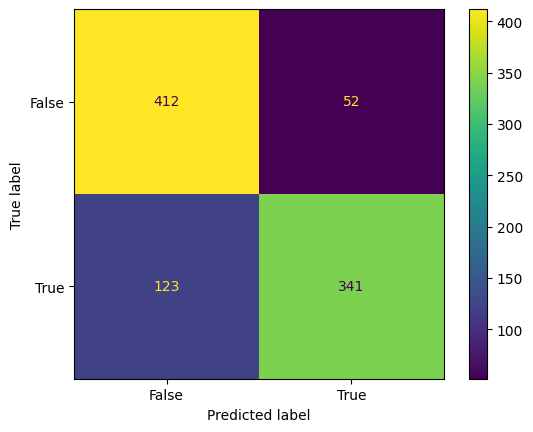

  # TP: 341.000000

  # TN: 412.000000

  # FP: 52.000000

  # FN: 123.000000

  # Accuracy: 0.811422

  # Precision: 0.867684

  # Sensitivity/Recall: 0.734914

  # Specificity: 0.887931

  # F1 score: 0.795799

  # Matthews Corrcoef:0.630267

Training Accuracy: 0.8336566440349176


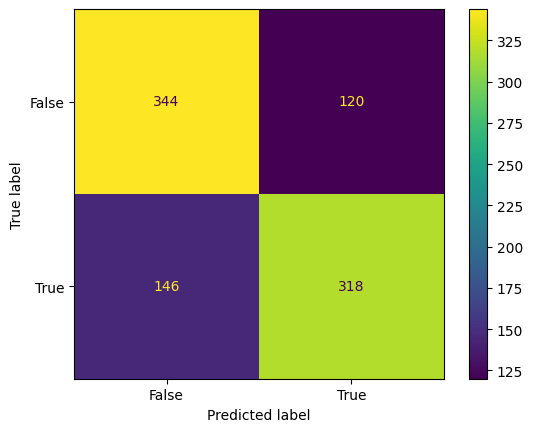

  # TP: 318.000000

  # TN: 344.000000

  # FP: 120.000000

  # FN: 146.000000

  # Accuracy: 0.713362

  # Precision: 0.726027

  # Sensitivity/Recall: 0.685345

  # Specificity: 0.741379

  # F1 score: 0.705100

  # Matthews Corrcoef:0.427396

Training Accuracy: 0.7419980601357905


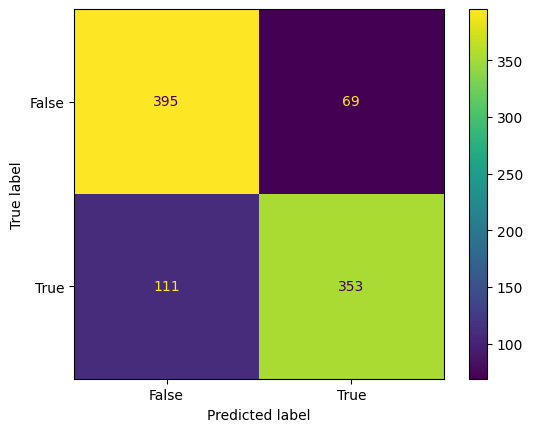

  # TP: 353.000000

  # TN: 395.000000

  # FP: 69.000000

  # FN: 111.000000

  # Accuracy: 0.806034

  # Precision: 0.836493

  # Sensitivity/Recall: 0.760776

  # Specificity: 0.851293

  # F1 score: 0.796840

  # Matthews Corrcoef:0.614592

Training Accuracy: 0.824078564500485


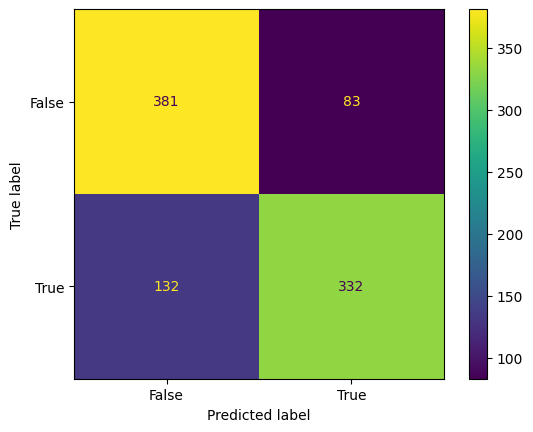

  # TP: 332.000000

  # TN: 381.000000

  # FP: 83.000000

  # FN: 132.000000

  # Accuracy: 0.768319

  # Precision: 0.800000

  # Sensitivity/Recall: 0.715517

  # Specificity: 0.821121

  # F1 score: 0.755404

  # Matthews Corrcoef:0.539656

Training Accuracy: 0.8083171677982541


In [10]:
models = {
    "XGBoost": xgb_model,
    "SVM": svm_model,
    "RandomForest": rf_model,
    "DecisionTree": dt_model,
}

for name, model in models.items():
    y_pred = model.predict(smote_test_X)
    evalution_metrics(smote_test_Y, y_pred, name)

    y_pred_train = model.predict(smote_train_X)
    print("Training Accuracy:",accuracy_score(smote_train_Y, y_pred_train.round()))

#### SHAP

In [11]:
import shap
shap.initjs()

In [12]:
explainer = shap.TreeExplainer(xgb_model)
smote_test_X = pd.DataFrame(smote_test_X, columns=selected_features)
shap_values = explainer(smote_test_X)

print(f"length of SHAP values: {len(shap_values)}")
print(f"Shape of each element: {shap_values.shape}")

length of SHAP values: 928
Shape of each element: (928, 20)


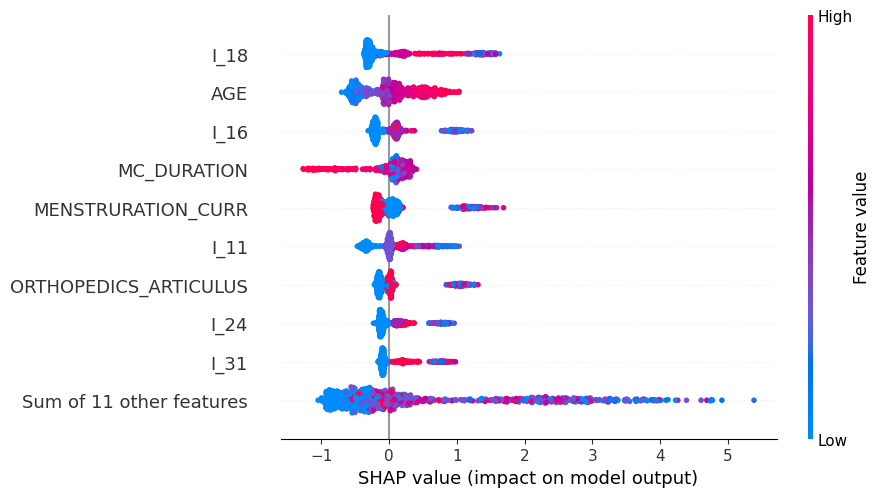

In [13]:
from shap.plots import colors

# shap.summary_plot(shap_values, smote_test_X, feature_names=feature_names)
# shap.summary_plot(shap_values[:, :, 1], bsmote_test_X, feature_names=feature_names)  # 顯示第一個值（正向影響）

shap.plots.beeswarm(shap_values)